In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid


In [2]:
dataset_path = 'datasets'

device = torch.device("mps")

batch_size = 100
x_dim = 784
hidden_dim = 400
latent_dim = 200 
lr = 0.001
epochs = 30

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root= dataset_path, train=True, transform=mnist_transform, download=True) 
test_dataset = MNIST(root= dataset_path, train=False, transform=mnist_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

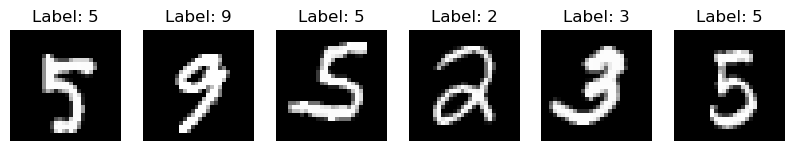

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_images(images, labels, num_images=6):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Extract a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the images
show_images(images, labels)


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fcvar = nn.Linear(hidden_dim, latent_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h_ = self.leaky_relu(self.fc1(x))
        h_ = self.leaky_relu(self.fc2(h_))
        mu = self.fcmu(h_)
        logvar = self.fcvar(h_)
        
        return mu, logvar

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fcout = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.leaky_relu(self.fc1(x))
        h = self.leaky_relu(self.fc2(h))
        x_hat = torch.sigmoid(self.fcout(h))
        return x_hat
        
        

In [7]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder
    def reparameterize(self, mu, var):
        eps = torch.randn_like(var).to(device)
        return mu + eps * var
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, torch.exp(0.5 * logvar))
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    

In [8]:
encoder = Encoder(x_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, x_dim)
model = VAE(encoder, decoder).to(device)

In [9]:
from torch.optim import Adam
 
loss_fn = nn.BCELoss()

def loss_function(x, recon_x, mu, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=1e-3)


In [10]:
print("Starting training...")
model.train()

for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function(x, x_hat, mu, logvar)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", total_loss / (batch_idx*batch_size))


Starting training...


100%|██████████| 600/600 [00:06<00:00, 89.45it/s]


	Epoch 1 complete! 	Average Loss:  175.20924136255738


100%|██████████| 600/600 [00:06<00:00, 93.14it/s] 


	Epoch 2 complete! 	Average Loss:  129.37513274076585


100%|██████████| 600/600 [00:06<00:00, 87.05it/s]


	Epoch 3 complete! 	Average Loss:  117.59605315499792


100%|██████████| 600/600 [00:06<00:00, 96.05it/s] 


	Epoch 4 complete! 	Average Loss:  113.22590559461081


100%|██████████| 600/600 [00:06<00:00, 99.80it/s] 


	Epoch 5 complete! 	Average Loss:  110.42865723471411


100%|██████████| 600/600 [00:05<00:00, 100.76it/s]


	Epoch 6 complete! 	Average Loss:  108.68022599514816


100%|██████████| 600/600 [00:05<00:00, 101.06it/s]


	Epoch 7 complete! 	Average Loss:  107.5047958837646


100%|██████████| 600/600 [00:05<00:00, 102.40it/s]


	Epoch 8 complete! 	Average Loss:  106.64928016420596


100%|██████████| 600/600 [00:06<00:00, 98.75it/s] 


	Epoch 9 complete! 	Average Loss:  105.79822756351732


100%|██████████| 600/600 [00:06<00:00, 93.05it/s] 


	Epoch 10 complete! 	Average Loss:  105.1624286571369


100%|██████████| 600/600 [00:06<00:00, 97.52it/s] 


	Epoch 11 complete! 	Average Loss:  104.48899249400041


100%|██████████| 600/600 [00:06<00:00, 94.42it/s] 


	Epoch 12 complete! 	Average Loss:  103.93018678591925


100%|██████████| 600/600 [00:06<00:00, 94.93it/s] 


	Epoch 13 complete! 	Average Loss:  103.54411333342028


100%|██████████| 600/600 [00:05<00:00, 101.55it/s]


	Epoch 14 complete! 	Average Loss:  103.17706093815212


100%|██████████| 600/600 [00:06<00:00, 99.86it/s] 


	Epoch 15 complete! 	Average Loss:  102.83740211550501


100%|██████████| 600/600 [00:06<00:00, 98.09it/s] 


	Epoch 16 complete! 	Average Loss:  102.52380472988835


100%|██████████| 600/600 [00:06<00:00, 94.87it/s] 


	Epoch 17 complete! 	Average Loss:  102.31186187591298


100%|██████████| 600/600 [00:06<00:00, 97.35it/s] 


	Epoch 18 complete! 	Average Loss:  102.05030418536101


100%|██████████| 600/600 [00:05<00:00, 101.34it/s]


	Epoch 19 complete! 	Average Loss:  101.81030817964837


100%|██████████| 600/600 [00:05<00:00, 103.37it/s]


	Epoch 20 complete! 	Average Loss:  101.63931105879591


100%|██████████| 600/600 [00:05<00:00, 102.16it/s]


	Epoch 21 complete! 	Average Loss:  101.5022899167884


100%|██████████| 600/600 [00:05<00:00, 100.22it/s]


	Epoch 22 complete! 	Average Loss:  101.32631604431866


100%|██████████| 600/600 [00:05<00:00, 101.06it/s]


	Epoch 23 complete! 	Average Loss:  101.21545097949708


100%|██████████| 600/600 [00:06<00:00, 97.21it/s] 


	Epoch 24 complete! 	Average Loss:  101.10938302118113


100%|██████████| 600/600 [00:06<00:00, 93.93it/s] 


	Epoch 25 complete! 	Average Loss:  100.93485084189795


100%|██████████| 600/600 [00:06<00:00, 97.90it/s] 


	Epoch 26 complete! 	Average Loss:  100.81530522876669


100%|██████████| 600/600 [00:06<00:00, 98.79it/s] 


	Epoch 27 complete! 	Average Loss:  100.68146538175606


100%|██████████| 600/600 [00:05<00:00, 101.36it/s]


	Epoch 28 complete! 	Average Loss:  100.62362588363418


100%|██████████| 600/600 [00:05<00:00, 102.69it/s]


	Epoch 29 complete! 	Average Loss:  100.525378723654


100%|██████████| 600/600 [00:06<00:00, 99.87it/s] 

	Epoch 30 complete! 	Average Loss:  100.37923841167571


In [11]:
import matplotlib.pyplot as plt

In [12]:
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        
        x_hat, _, _ = model(x)

100%|██████████| 100/100 [00:00<00:00, 250.73it/s]


In [13]:
def show_image (x,idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())
    

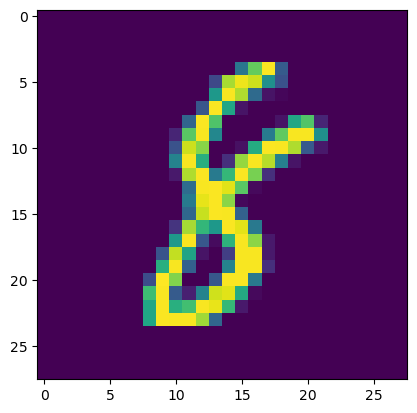

In [14]:
show_image(x,idx=0)

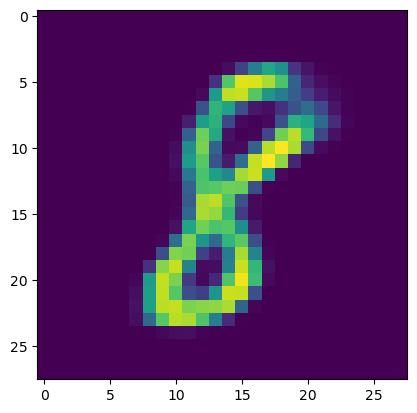

In [15]:
show_image(x_hat,idx=0)

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(device)
    generated_images = decoder(noise)

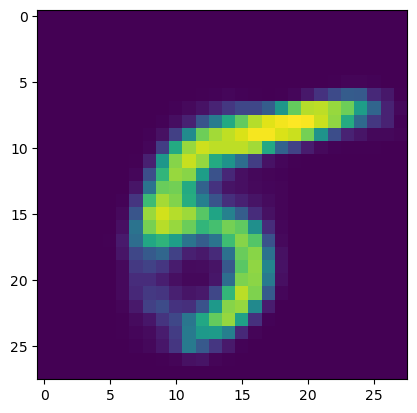

In [17]:
show_image(generated_images, idx=3)
